## Laboratorio 6: Análisis de tráfico de red

#### Brandon Ronaldo Sicay Cumes - 21757

### **Preámbulo**


1. Cargue la información del archivo large_even.json en una lista, muestre la cantidad de
registros total (deben ser 746, 909). Este es nuestro tráfico inicial!

In [2]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np 
import binascii # Binary to Ascii
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

#### **a. Capture 25 paquetes de su red doméstica (no de la red de la UVG) y asígnelos a una variable**
#### **b. Imprima el tipo de variable, la longitud y el contenido de la variable.**
#### **c. Imprima el tipo de dato del primer paquete capturado.**
#### **d. Imprima el contenido de 5 paquetes**

In [43]:
num_of_packets_to_sniff = 25
pcap = sniff(count=num_of_packets_to_sniff)

# rdpcap returns packet list
## packetlist object can be enumerated
print("Tipo de variable", type(pcap))
print("Longitud de paquetes", len(pcap))

print("Tipo de dato del primer paquete: ", type(pcap[0]))


print("\nContenido de los primeros 5 paquetes:")
for i in range(5):
    print("Tipo de variable:", type(pcap[i]))
    print("Longitud del paquete:", len(pcap[i]))
    print("Contenido del paquete:", pcap[i])

Tipo de variable <class 'scapy.plist.PacketList'>
Longitud de paquetes 25
Tipo de dato del primer paquete:  <class 'scapy.layers.l2.Ether'>

Contenido de los primeros 5 paquetes:
Tipo de variable: <class 'scapy.layers.l2.Ether'>
Longitud del paquete: 54
Contenido del paquete: Ether / IP / TCP 192.168.0.2:56916 > 140.82.114.25:https A
Tipo de variable: <class 'scapy.layers.l2.Ether'>
Longitud del paquete: 66
Contenido del paquete: Ether / IP / TCP 140.82.114.25:https > 192.168.0.2:56916 A
Tipo de variable: <class 'scapy.layers.l2.Ether'>
Longitud del paquete: 87
Contenido del paquete: Ether / IP / UDP / mDNS Qry b'_spotify-connect._tcp.local.'
Tipo de variable: <class 'scapy.layers.l2.Ether'>
Longitud del paquete: 87
Contenido del paquete: Ether / IP / UDP / mDNS Qry b'_spotify-connect._tcp.local.'
Tipo de variable: <class 'scapy.layers.l2.Ether'>
Longitud del paquete: 107
Contenido del paquete: Ether / IPv6 / UDP / mDNS Qry b'_spotify-connect._tcp.local.'


### **Análisis estadístico**


1. Descargue e archivo analisis_paquetes.pcap y asignelo a una variable

In [46]:
pcap_file = "analisis_paquetes.pcap"
pcap = rdpcap(pcap_file)
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload', 'payload_raw', 'payload_hex']
df = pd.DataFrame(columns=dataframe_fields)

2. Convierta la variable a un DataFrame.


In [47]:
import pandas as pd

# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])

    field_values.append(packet.time)

    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)

    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")


3. Muestre el contenido de las primeras 5 filas del dataset.


In [48]:
print("Contenido de las primeras 5 filas del dataset:")
print(df.head())

Contenido de las primeras 5 filas del dataset:
  version ihl tos   len     id flags frag  ttl proto chksum  ... dataofs  \
0       4   5   0   961      1          0   64    17  21222  ...    None   
1       4   5  32    84  58919          0  122    17  13836  ...    None   
2       4   5   0   975      1          0   64    17  21208  ...    None   
3       4   5  32    84  59493          0  122    17  13262  ...    None   
4       4   5   0  1012      1          0   64    17  21171  ...    None   

  reserved flags window chksum urgptr options payload  \
0     None  None   None  62990   None    None     933   
1     None  None   None  65061   None    None      56   
2     None  None   None  36378   None    None     947   
3     None  None   None  65063   None    None      56   
4     None  None   None  63846   None    None     984   

                                         payload_raw  \
0  b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...   
1  b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00

4. Muestre los valores de las columnas: Src Addres, Dst Address, sport y dport.


In [49]:
print("\nValores de las columnas:")
print("Src Address:", df['src'].unique())
print("Dst Address:", df['dst'].unique())
print("Src Port:", df['sport'].unique())
print("Dst Port:", df['dport'].unique())


Valores de las columnas:
Src Address: ['10.1.10.53' '84.54.22.33' '75.75.75.75']
Dst Address: ['84.54.22.33' '10.1.10.53' '75.75.75.75']
Src Port: [53 15812 23903]
Dst Port: [53 15812 23903]


5. Estadísticas

    a. Muestre todas las IP origen

    b. Muestre todas las IP destino

    c. ¿Cuál es la IP origen más frecuente?
    
           La IP: 10.1.10.53

    i. ¿A qué IP destino se comunica con más frecuencia?

           IP destino: 10.1.10.53
    
    ii. ¿A que puerto destino se comunica? ¿Cuál es el propósito de este puerto?
              
              Al puesto 53:
                     El puerto 53 está destinado al funcionamiento del servicio DNS. Este protocolo se encarga de convertir nombres de dominio como "google.com" en direcciones IP. En consecuencia, el tráfico que se dirige al puerto 53 suele estar asociado a solicitudes y respuestas DNS, facilitando así la comunicación entre dispositivos mediante nombres de dominio en lugar de utilizar directamente direcciones IP.
    iii. ¿Desde que puertos origen se comunica?

              53
              15812
              23903

In [50]:
# Mostrar todas las IP origen
print("a. Todas las IP origen")
print(df['src'].unique())
# Mostrar todas las IP destino
print("b. Todas las IP destino")
ips_destino = df["dst"].unique()
for ip in ips_destino:
    print("- ", ip)

# ¿Cuál es la IP origen más frecuente?
print("\nc. IP origen más frecuente")
ip_origen_frecuente = df["src"].value_counts().idxmax()
print(ip_origen_frecuente)

#  ¿A qué IP destino se comunica con más frecuencia?
print("\ni. IP destino más frecuente")
ip_destino_frecuente = df["dst"].value_counts().idxmax()
print(ip_destino_frecuente)

# ¿A que puerto destino se comunica? ¿Cuál es el propósito de este puerto?
print("\nii. Puerto destino más frecuente")
puerto_destino_frecuente = df[df["dst"] == ip_destino_frecuente]["dport"].value_counts().idxmax()
print(puerto_destino_frecuente)

# ¿Desde que puertos origen se comunica?
print("\niii. Puertos origen")
puertos_origen = df["sport"].unique()
for puerto in puertos_origen:
    print("- ", puerto)

a. Todas las IP origen
['10.1.10.53' '84.54.22.33' '75.75.75.75']
b. Todas las IP destino
-  84.54.22.33
-  10.1.10.53
-  75.75.75.75

c. IP origen más frecuente
10.1.10.53

i. IP destino más frecuente
10.1.10.53

ii. Puerto destino más frecuente
53

iii. Puertos origen
-  53
-  15812
-  23903


### **Gráficas**


a. Genere una gráfica de barras 2D horizontales, en el eje Y las IPs origen, y en el eje X la
suma de los payloads (bytes) enviados desde dichas direcciones.

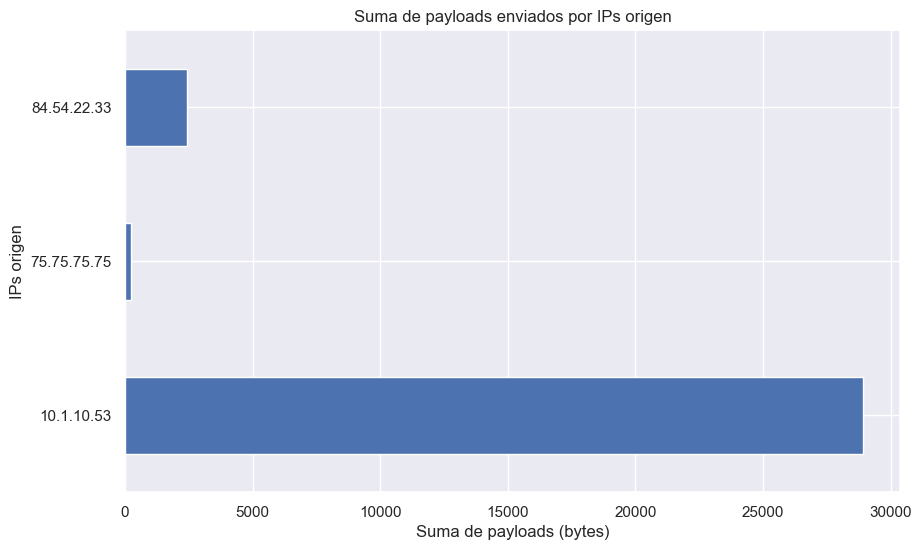

In [53]:
plt.figure(figsize=(10, 6))
df.groupby("src")["len"].sum().plot(kind="barh")
plt.xlabel("Suma de payloads (bytes)")
plt.ylabel("IPs origen")
plt.title("Suma de payloads enviados por IPs origen")
plt.show()

b. Genere una gráfica de barras 2D horizontales, en el eje Y las IP destino, y en el eje X
la suma de los payloads (bytes) recibidos en dichas direcciones.

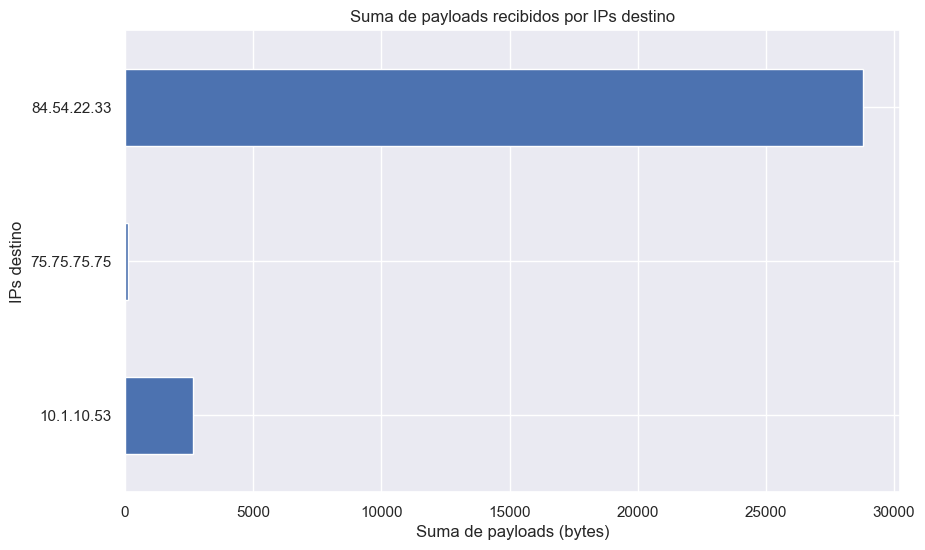

In [54]:
plt.figure(figsize=(10, 6))
df.groupby("dst")["len"].sum().plot(kind="barh")
plt.xlabel("Suma de payloads (bytes)")
plt.ylabel("IPs destino")
plt.title("Suma de payloads recibidos por IPs destino")
plt.show()

c. Genere una gráfica de barras 2D horizontales, en el eje Y los puertos origen, y en el
eje X la suma de los payloads (bytes) enviados de dichos puertos.

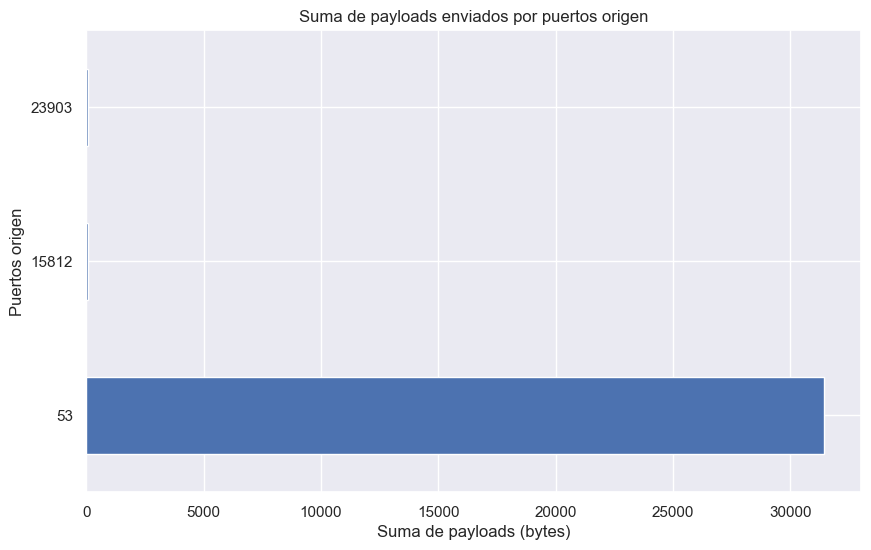

In [55]:
plt.figure(figsize=(10, 6))
df.groupby("sport")["len"].sum().plot(kind="barh")
plt.xlabel("Suma de payloads (bytes)")
plt.ylabel("Puertos origen")
plt.title("Suma de payloads enviados por puertos origen")
plt.show()

d. Genere una gráfica 2D de barras horizontales, en el eje Y los puertos destino, y en el
eje X la suma de los payloads (bytes) recibidos en dichos puertos

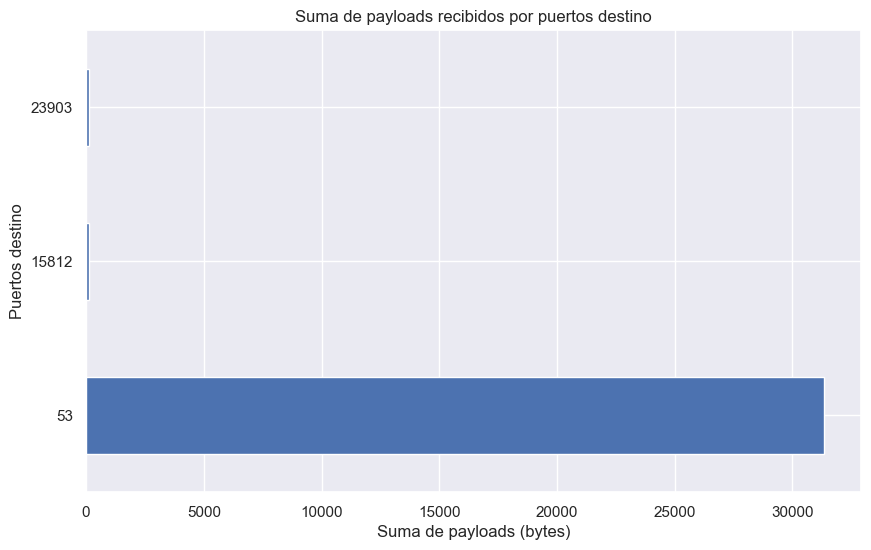

In [56]:
plt.figure(figsize=(10, 6))
df.groupby("dport")["len"].sum().plot(kind="barh")
plt.xlabel("Suma de payloads (bytes)")
plt.ylabel("Puertos destino")
plt.title("Suma de payloads recibidos por puertos destino")
plt.show()

e. Genere una gráfica de barras 2D verticales, en el eje Y la suma de los payload, en el
eje X el tiempo, para la IP origen más frecuente

<Figure size 1000x600 with 0 Axes>

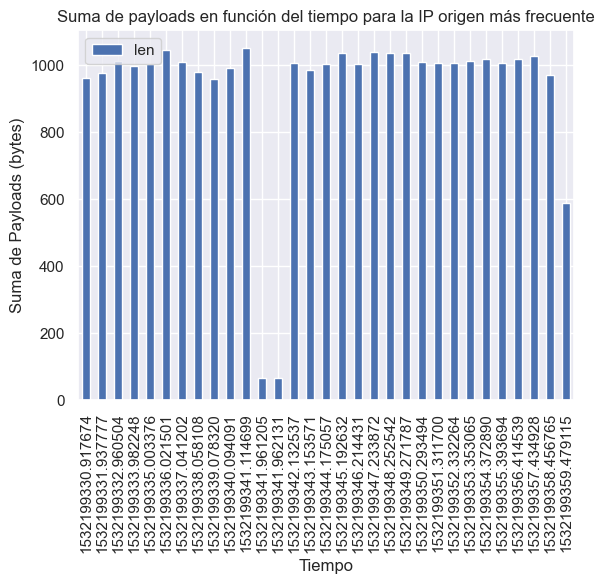

In [58]:
plt.figure(figsize=(10, 6))
df[df['src'] == ip_origen_frecuente].plot(x='time', y='len', kind='bar', stacked=True)
plt.title('Suma de payloads en función del tiempo para la IP origen más frecuente')
plt.xlabel('Tiempo')
plt.ylabel('Suma de Payloads (bytes)')
plt.show()

f. Utilizando la información de las estadísticas y la información del comportamiento del
tráfico que las gráficas muestran, describa que es lo que está sucediendo. ¿Es común
el comportamiento?

En general el comportamiento se mantiene similar, exceptuando por un par de marcas de tiempo donde la suma de payloads es muy baja en comparación a las demás, este comportamiento podría deberse a periodos de inactividad o problemas dentro de la red. También podrían representar una optimización en el envío de información y en dichas marcas de tiempo la cantidad de datos transferidos se minimizó.

### **Investigación del payload**


a. Cree un nuevo DF que incluya únicamente las conexiones con la dirección IP origen
más frecuente

In [59]:
df_frequent_src = df[df['src'] == ip_origen_frecuente]


b. Cree un nuevo DF que utilice el DF anterior con las columnas src, dst y payload y
agrúpelas por dst y la suma del payload,


In [60]:
df_grouped_dst_payload = df_frequent_src.groupby('dst')['payload'].sum().reset_index()


c. Obtenga la IP destino que más ha intercambiado bytes con la IP más frecuente. Esta
IP es sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones.


In [61]:
df_grouped_dst_payload['payload'] = pd.to_numeric(df_grouped_dst_payload['payload'])  # Convertir la columna 'payload' a datos numéricos
suspicious_dst_ip = df_grouped_dst_payload.loc[df_grouped_dst_payload['payload'].idxmax()]['dst']

d. Cree un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa.


In [62]:
df_suspicious_conversation = df_frequent_src[df_frequent_src['dst'] == suspicious_dst_ip]


e. Obtenga los payloads del DF del inciso anterior, y añada cada uno en un array.


In [63]:
payload_array = df_suspicious_conversation['payload_raw'].values


f. Muestre el contenido del array.


In [64]:
print("Contenido del array de payloads:")
print(payload_array)

Contenido del array de payloads:
[b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xbf\xbd8c\xef\xbf\xbdew\r\x1e\xef\xbf\x

g. Observe los primeros bytes del contenido, ¿encuentra algún tipo de dato que no haga
sentido que se envíe al puerto destino? Describa lo que encontró.

In [65]:
print("\nPrimeros bytes del contenido de los payloads:")
for i, payload in enumerate(payload_array[:5]):
    print("Payload", i+1, ":", payload[:10])  # Mues


Primeros bytes del contenido de los payloads:
Payload 1 : b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00'
Payload 2 : b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00'
Payload 3 : b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00'
Payload 4 : b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00'
Payload 5 : b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00'


El arreglo de payloads contiene diversos datos en formato binario, como archivos, imágenes u otros tipos de información. Los primeros bytes de cada payload pueden proporcionar pistas clave sobre el tipo de contenido transmitido, lo cual es útil para detectar anomalías o comportamientos inusuales. En general, la mayoría de las solicitudes siguen un mismo patrón, similar al que presentan los payloads del 1 al 5. Estos bytes iniciales coinciden con la estructura típica de una petición DNS, incluyendo elementos como el identificador de transacción, banderas de la solicitud y el número de preguntas, entre otros campos.